In [27]:
import matplotlib.pyplot as plt
from time import perf_counter_ns,sleep
import numpy as np
import opt, raw
from scipy.special import gamma
from scipy.stats import ttest_ind
from scalene import scalene_profiler
# Load Scalene
%load_ext scalene

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


# Calibrando la estadística de la varianza en la toma de datos del PC

Para conocer que tanto error tenemos al tomar el tiempo entre una serie de operaciones, vamos a calcular la varianza que tiene el método "perf_counter_ns()" de la libreria time de Python. Para ello, tomaremos el tiempo al inicio y final de un sleep de $10^{-8}$ segundos y usaremos como modelo de error ruido gaussiano blanco. Lo que nos daría que la distribución de los tiempos entregados por el método "perf_counter_ns()" toma la siguiente forma:

$$
m(x) := x + \epsilon \ | \ \epsilon \sim N(0,\sigma^2) \\
\Leftrightarrow m(x) \sim N(x,\sigma^{2})
$$

Dado este modelo y que sabemos cuánto es el tiempo promedio ideal al medir el tiempo, podemos usar actualización bayesiana por medio de conjugados para encontrar la varianza de esta operación. En este caso, cuando conocemos el valor promedio de una normal, la distribución que toma la varianza es una Gamma Inversa, tal que:

$$
\alpha_{k+1} = \alpha_{k} + \dfrac{n}{2} \\
\beta_{k+1} = \beta_{k} + \dfrac{\sum_{i=1}^n(x_i-\mu)^2}{2} \\
IG(x; \alpha, \beta) = \dfrac{\beta^{\alpha}}{\Gamma(\alpha)}(1/x)^{\alpha+1}\exp{(-\beta/x)}
$$

Partiremos con $\alpha =1$ y $\beta=1$.


In [21]:
float(0b110101010101010100111)

1747623.0

In [32]:
2.2*np.array([[2**i * 0.5**j for j in range(10)] for i in range(10)])

array([[2.200000e+00, 1.100000e+00, 5.500000e-01, 2.750000e-01,
        1.375000e-01, 6.875000e-02, 3.437500e-02, 1.718750e-02,
        8.593750e-03, 4.296875e-03],
       [4.400000e+00, 2.200000e+00, 1.100000e+00, 5.500000e-01,
        2.750000e-01, 1.375000e-01, 6.875000e-02, 3.437500e-02,
        1.718750e-02, 8.593750e-03],
       [8.800000e+00, 4.400000e+00, 2.200000e+00, 1.100000e+00,
        5.500000e-01, 2.750000e-01, 1.375000e-01, 6.875000e-02,
        3.437500e-02, 1.718750e-02],
       [1.760000e+01, 8.800000e+00, 4.400000e+00, 2.200000e+00,
        1.100000e+00, 5.500000e-01, 2.750000e-01, 1.375000e-01,
        6.875000e-02, 3.437500e-02],
       [3.520000e+01, 1.760000e+01, 8.800000e+00, 4.400000e+00,
        2.200000e+00, 1.100000e+00, 5.500000e-01, 2.750000e-01,
        1.375000e-01, 6.875000e-02],
       [7.040000e+01, 3.520000e+01, 1.760000e+01, 8.800000e+00,
        4.400000e+00, 2.200000e+00, 1.100000e+00, 5.500000e-01,
        2.750000e-01, 1.375000e-01],
       [1.

In [25]:
1 <<1

2

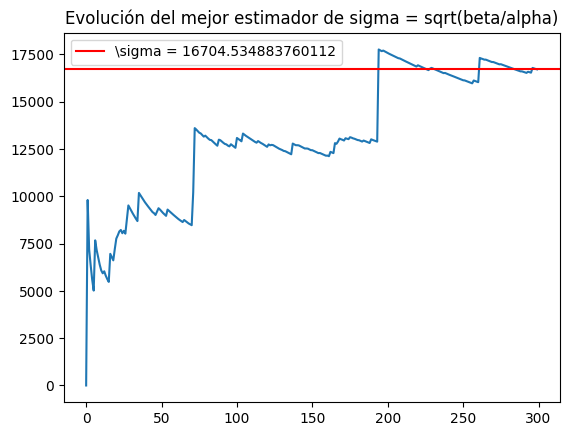

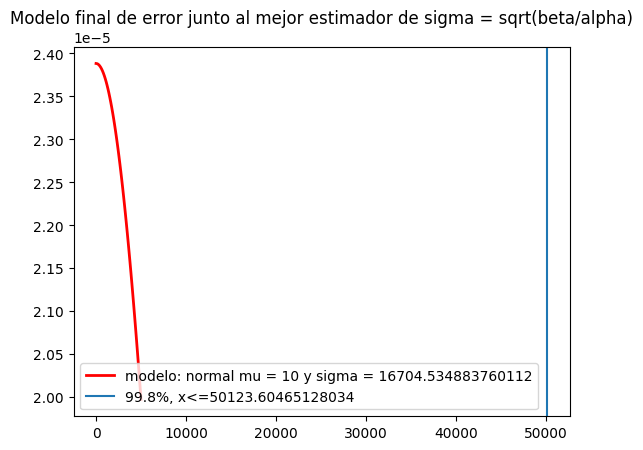

In [2]:
n = 300 # Número de datos por iteración
m = 300 # Número de iteraciones

alpha = np.zeros(m)
beta = np.zeros(m)
mu = 10

alpha[0] = 1
beta[0] = 1

for i in range(m-1):
    data = np.zeros(n)
    for j in range(n):
        ini = perf_counter_ns()
        sleep(1e-8)
        fin = perf_counter_ns()
        data[j] = fin - ini
    beta[i+1] = beta[i] + ((data-mu)**2).sum()/2
    alpha[i+1] = alpha[i] + (m*n)/2


plt.plot(range(m),np.sqrt(beta/alpha))
std_error = np.sqrt(beta[-1]/alpha[-1]) # No modificar
plt.axhline(std_error, label=f"\sigma = {std_error}", c="r")
plt.title("Evolución del mejor estimador de sigma = sqrt(beta/alpha)")
plt.legend()
plt.show()

plt.plot(np.linspace(0,5_000), 1/(std_error * np.sqrt(2 * np.pi)) *
         np.exp( - (np.linspace(0,10_000) - mu)**2 / (2 * std_error**2) ),
         linewidth=2, color='r', label=f"modelo: normal mu = {mu} y sigma = {std_error}")
plt.axvline(mu+3*std_error, label=f"99.8%, x<={mu+3*std_error}")
plt.title("Modelo final de error junto al mejor estimador de sigma = sqrt(beta/alpha)")
plt.legend()
plt.show()

Nuestro mejor estimador de $\sigma_{error}^2$ para nuestro modelo es:
$$
\hat{\sigma}_{error}^2 =\dfrac{\beta}{\alpha}
$$
Los algoritmos tendrán tiempo esperado $\hat{\mu} = \bar{x}$ y estimaremos la cota del peor caso del algoritmo, como $\bar{x} + 3s^2$. Estas serán las métricas para evaluar que más eficiente es el algoritmo optimizado.

Dado que no conocemos la distribución de tiempos del ningún algoritmo, pero si la distribución de nuestro error, podemos decir que:
$$
t_i = t_{i}^{(real)} + \epsilon \ | \ \epsilon \sim N(0, \sigma_{error}^2)
$$

Entonces, si calculamos el tiempo promedio y la varianza se tiene que:
$$
E[T] = E[T^{(real)} + \epsilon] \rightarrow E[T^{(real)}] + E[\epsilon]\\
\rightarrow E[T] = E[T^{(real)}]
\rightarrow E[T^{(real)}] = \bar{x}
$$
Recordemos que los errores de medición no debiesen depender de cuánto tiempo toma el algoritmo realmente. Lo que implica que $Cov(T^{(real)},\epsilon) = 0$
$$
Var[T] = Var[T^{(real)} + \epsilon] \rightarrow Var[T^{(real)}] + Var[\epsilon]\\
\rightarrow Var[T] = Var[T^{(real)}] + \hat{\sigma}_{error}^2\\
\rightarrow Var[T^{(real)}] =  s^2 -\hat{\sigma}_{error}^2
$$

In [61]:
x = np.array([0,1,2])

x[-2:] = x[:-1]
x

array([0, 0, 1])

In [35]:
a = [1, 2, 3, 4, 5]
np.linalg.norm(a[:-1])

5.477225575051661

In [3]:
def experiment(input: tuple, fun1, fun2) -> tuple[int,int]:
    t0 = perf_counter_ns()
    fun1(*input)
    t1 = perf_counter_ns()
    fun2(*input)
    t2 = perf_counter_ns()
    return t1 - t0, t2 - t1

def comparativa(fun1, fun2, input_array: list[tuple]):
    list_experiments = [experiment(x, fun1,fun2)
                        for x in input_array]
    a, b = zip(*list_experiments)
    print("Comparando las funciones... \n")
    print(f"{fun1.__name__} \n")
    print(f"{fun2.__name__} \n")
    if ttest_ind(a,b,equal_var=False).pvalue > 0.05:
        print("No hay cambios destacables.\n")
    else:
        print("### Hay cambios destacables. #####\n")
    print(f"{fun1.__name__} toma en promedio: {np.array(a).mean()} ns\n")
    print(f"{fun2.__name__} toma en promedio: {np.array(b).mean()} ns\n")

In [14]:
%scrun map(lambda x: opt.square_loss(*x), [(f, y) for f in np.linspace(-10,10,10000) for y in [-1,1]])

SCRUN MAGIC
Scalene: Program did not run for long enough to profile.


In [29]:
def comparar(inputs, fun1, fun2):
    sleep(1)
    for x in inputs:
        fun1(*x)
        fun2(*x)
    return

In [23]:
inputs = [(f, y)
          for f in np.linspace(-10,10,10000)
          for y in [-1,1]]

In [33]:
%scrun comparar(inputs,raw.square,opt.square_loss)

SCRUN MAGIC


In [28]:

comparativa(raw.square,opt.square_loss, inputs)

Comparando las funciones... 

square 

square_loss 

### Hay cambios destacables. #####

square toma en promedio: 853.915 ns

square_loss toma en promedio: 735.41 ns


In [36]:
comparativa(raw.hinge,opt.hinge_loss, inputs)

Comparando las funciones... 

hinge 

hinge_loss 

### Hay cambios destacables. #####

hinge toma en promedio: 1153.385 ns

hinge_loss toma en promedio: 1032.845 ns


In [43]:
comparativa(raw.smoothinge,opt.smooth_hinge_loss, inputs)

Comparando las funciones... 

smoothinge 

smooth_hinge_loss 

### Hay cambios destacables. #####

smoothinge toma en promedio: 1286.85 ns

smooth_hinge_loss toma en promedio: 5557.515 ns


In [15]:
comparativa(raw.modsquare,opt.mod_square_loss, inputs)

Comparando las funciones... 

modsquare 

mod_square_loss 

No hay cambios destacables.

modsquare toma en promedio: 1179.41 ns

mod_square_loss toma en promedio: 1141.57 ns


In [16]:
comparativa(raw.exp,opt.exp_loss, inputs)

Comparando las funciones... 

exp 

exp_loss 

### Hay cambios destacables. #####

exp toma en promedio: 748.365 ns

exp_loss toma en promedio: 701.92 ns


In [17]:
comparativa(raw.log,opt.log_loss, inputs)

Comparando las funciones... 

log 

log_loss 

### Hay cambios destacables. #####

log toma en promedio: 1100.51 ns

log_loss toma en promedio: 1019.8 ns


In [18]:
inputs2 =[(f, y, 0.1, th, 0.5)
          for f in np.linspace(-10,10,1000)
          for y in [-1,1]
          for th in np.linspace(1e-10,1-1e-10)
]
comparativa(raw.sigmoid,opt.sigmoid_loss, inputs2)

Comparando las funciones... 

sigmoid 

sigmoid_loss 

No hay cambios destacables.

sigmoid toma en promedio: 855.288 ns

sigmoid_loss toma en promedio: 850.857 ns


In [19]:
comparativa(raw.phi,opt.phi_learning, inputs)

Comparando las funciones... 

phi 

phi_learning 

### Hay cambios destacables. #####

phi toma en promedio: 1105.11 ns

phi_learning toma en promedio: 3230.025 ns
